# Iris Plant Species Classification

## Analyze the data using the same techniques as for the last assignment.
Decide for yourself which and how to use the specific commands. Answer
the following questions in the report and include figures supporting your
answers:

### Which classes exist? Are they (roughly) balanced?

In [88]:


import matplotlib as plt
import pandas as pd
from sklearn import preprocessing

import utils

plt.rc('font', size=16)

df = pd.read_csv('iris.csv')
utils.ratio(df, 'Name')

,samples,ratio
Name,,
Iris-setosa,50,1.0
Iris-versicolor,50,1.0
Iris-virginica,50,1.0


Classes: Iris-setosa, Iris-versicolor, Iris-virginica
They are perfectly balanced.

### Which noteworthy trends of features and relations between features as well as features and Classes do you see?

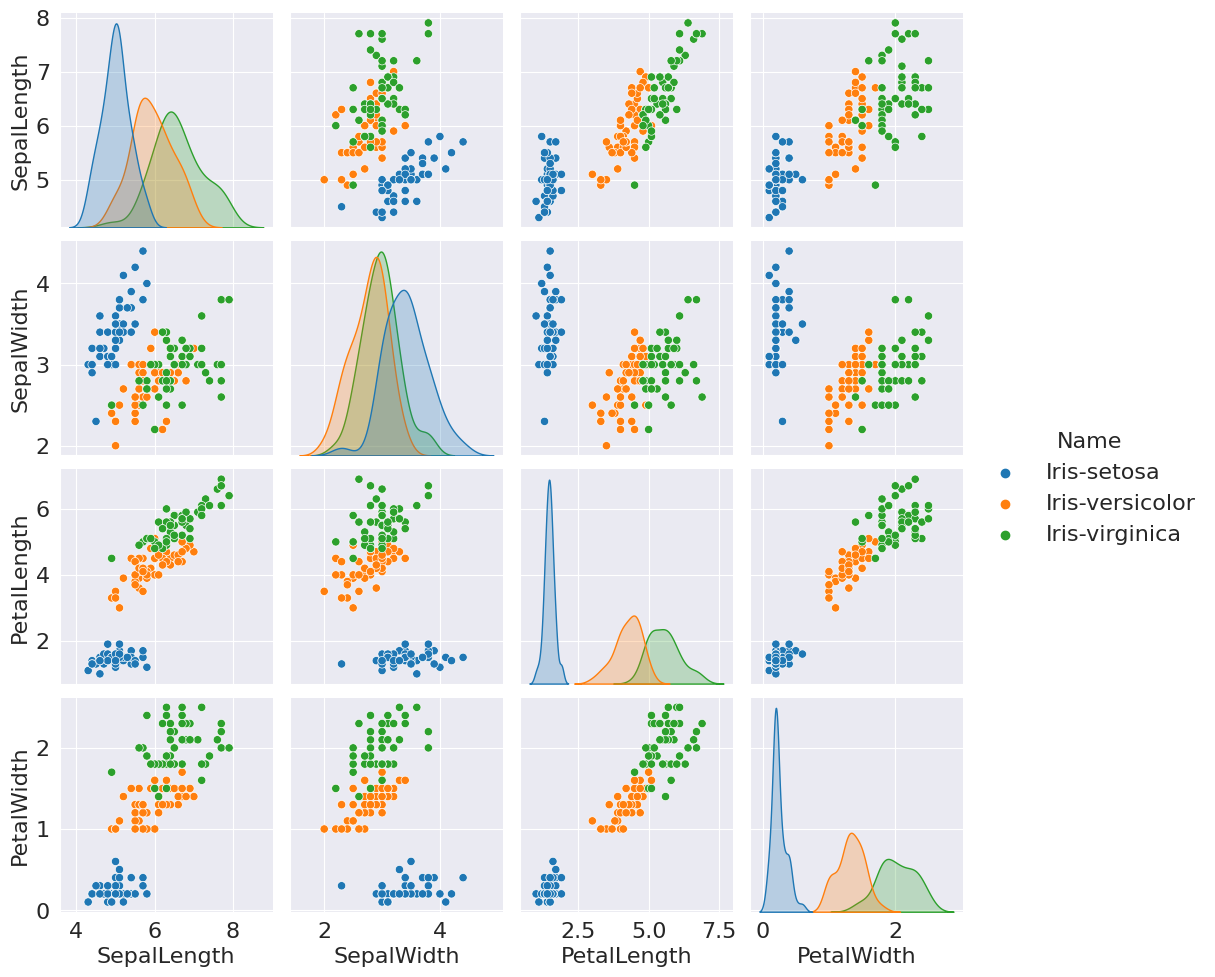

In [89]:
import seaborn as sns

sns.pairplot(df, hue='Name')

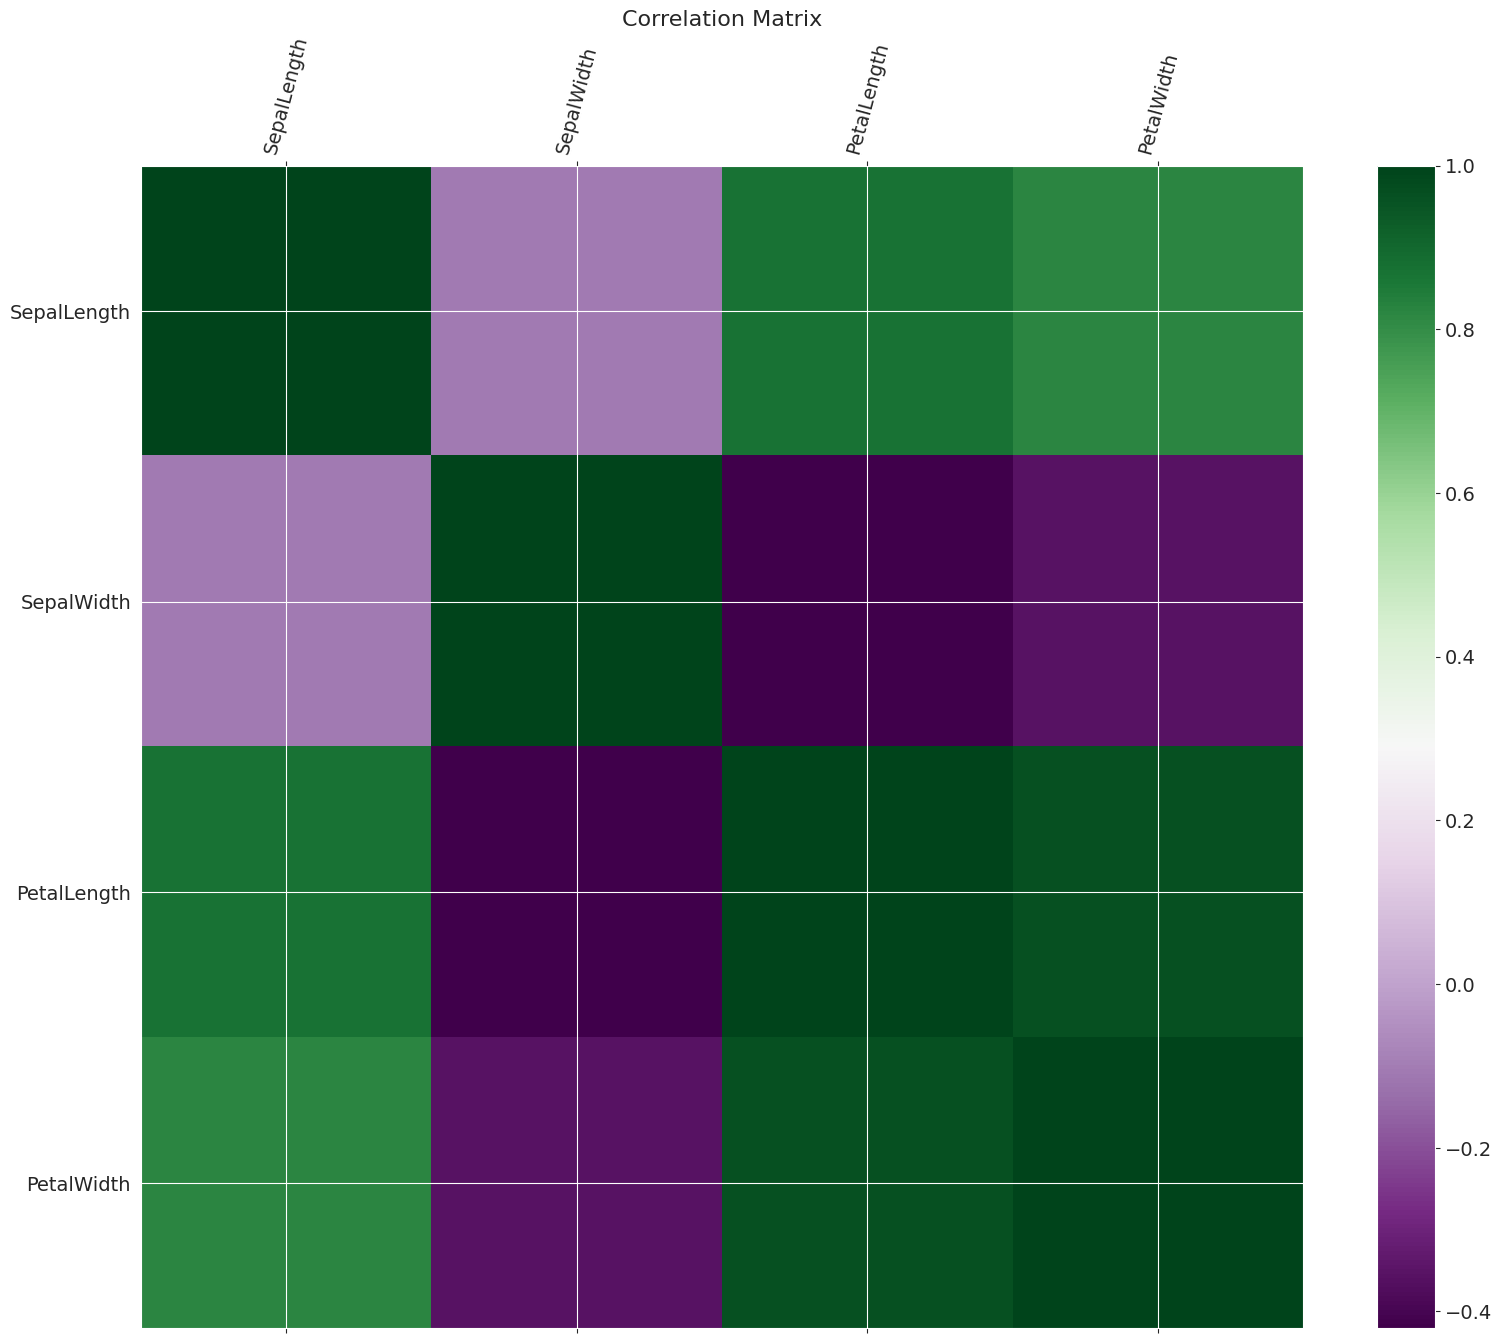

In [90]:
utils.piggy_matrix(df)

PetalLength       AxesSubplot(0.125,0.11;0.168478x0.77)
PetalWidth     AxesSubplot(0.327174,0.11;0.168478x0.77)
SepalLength    AxesSubplot(0.529348,0.11;0.168478x0.77)
SepalWidth     AxesSubplot(0.731522,0.11;0.168478x0.77)
dtype: object

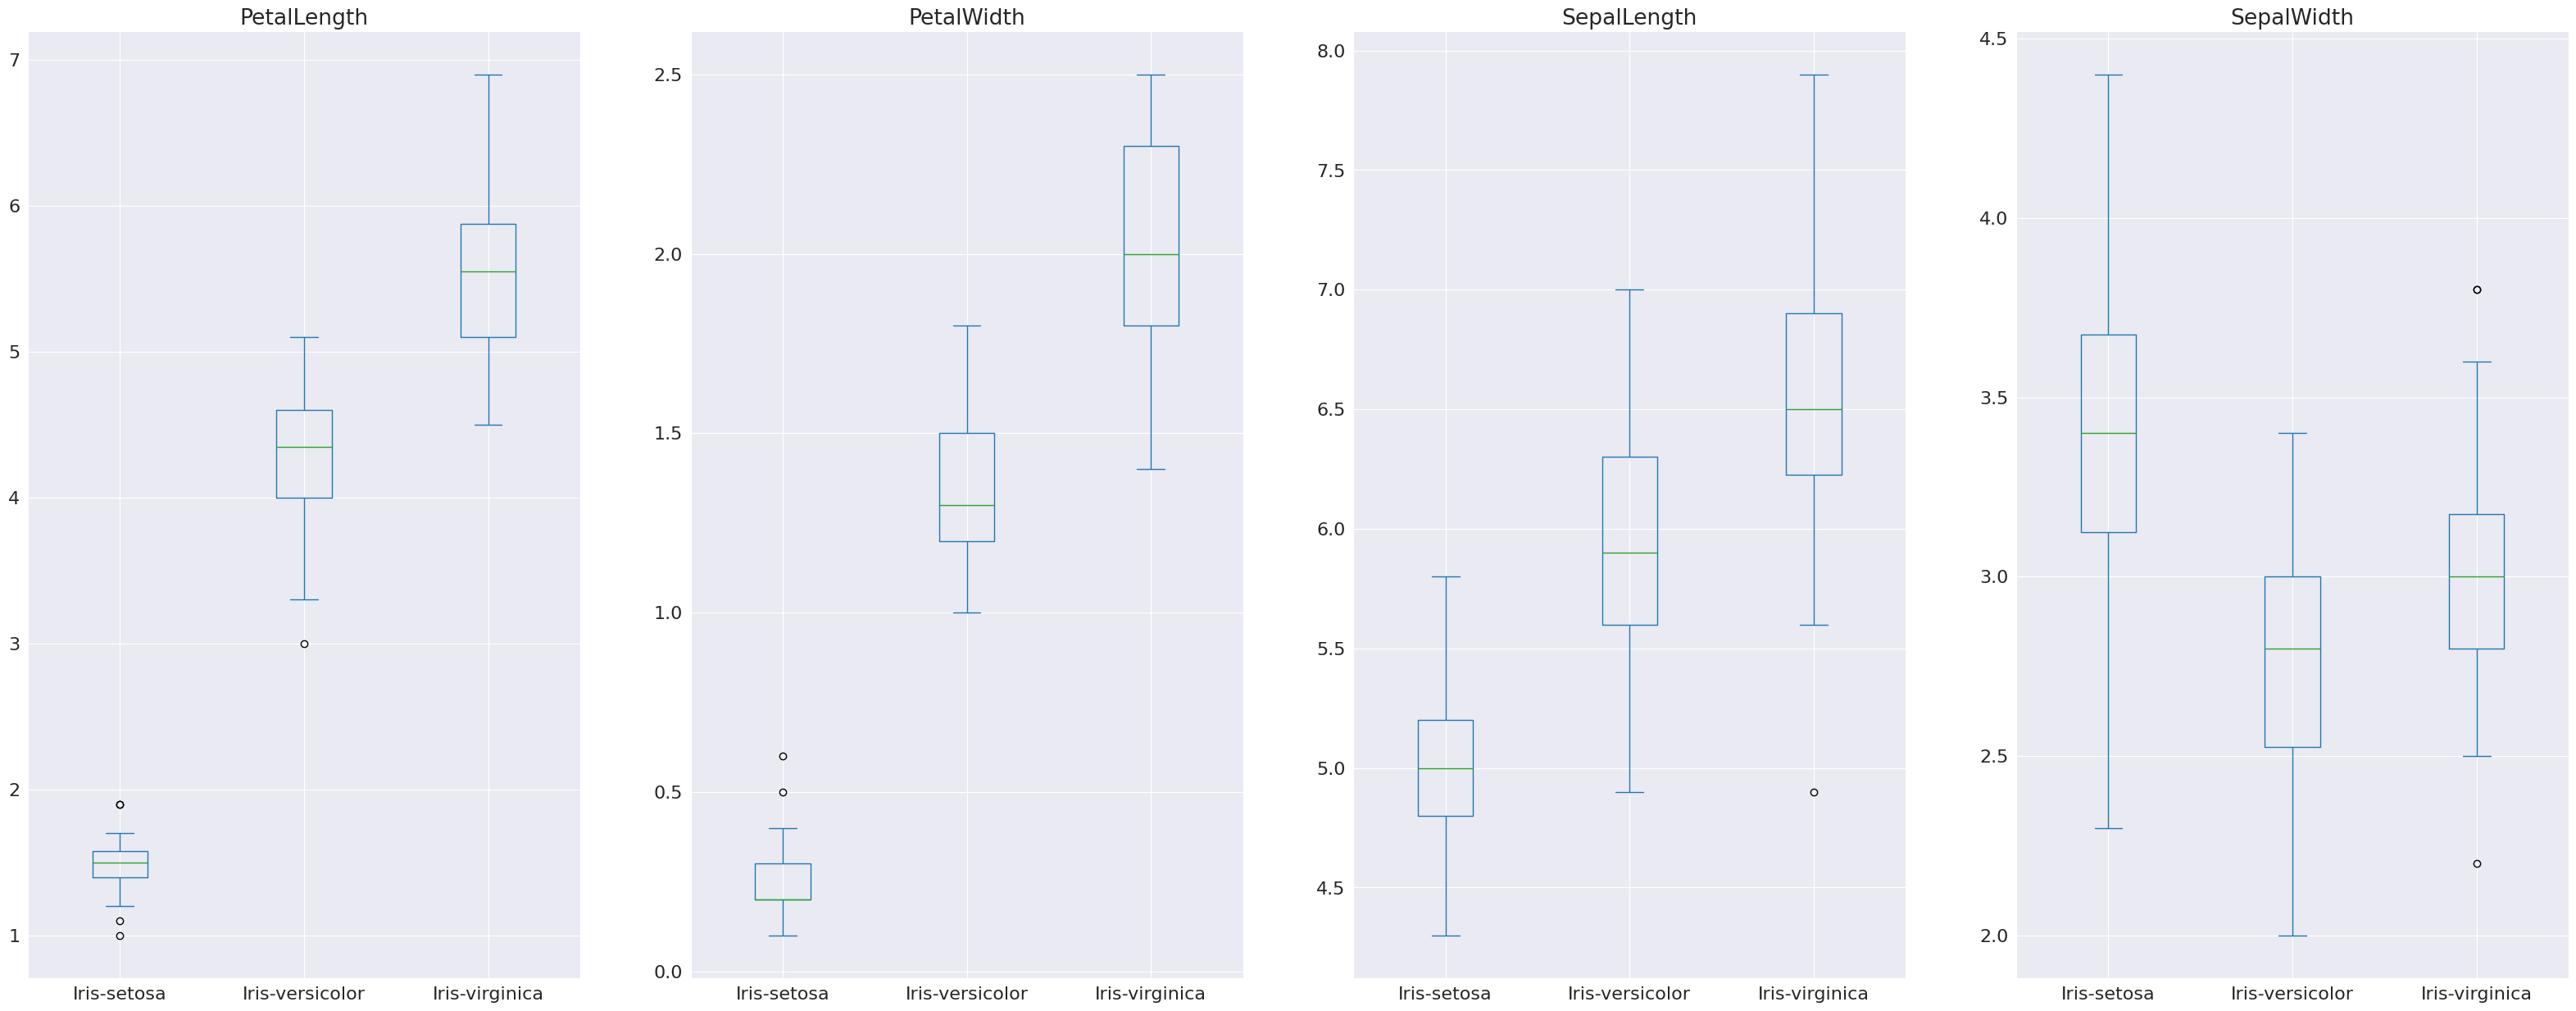

In [91]:
df.plot.box(by='Name',figsize=(40, 15), fontsize=16)

PetalLength and PetalWidth correlate well.
PetalLength and SepalWidth correlate negatively. (see correlation matrix above)
PetalLength and PetalWidth are well segmented and can be used to distinguish.

### If you would need to distinguish the classes with those features, which features would you choose, any why?

PetalLength and PetalWidth because they don't overlap significantly. (see boxplot above)
SepalLength and SepalWidth are not ideal to distinguish between flowers, since these features tend to overlap more, than any other feature.

## In order to classify the three different Iris plant species, set up your first
ML toolchain including the following steps:

### Data and Feature Preprocessing (if necessary and applicable)
* Are there any outliers in the data which might need to be removed?

In [92]:
X = df[['PetalLength', 'PetalWidth', 'SepalLength', 'SepalWidth']]
X.describe()

,PetalLength,PetalWidth,SepalLength,SepalWidth
count,150.000000,150.000000,150.000000,150.000000
mean,3.758667,1.198667,5.843333,3.054000
std,1.764420,0.763161,0.828066,0.433594
min,1.000000,0.100000,4.300000,2.000000
25%,1.600000,0.300000,5.100000,2.800000
50%,4.350000,1.300000,5.800000,3.000000
75%,5.100000,1.800000,6.400000,3.300000
max,6.900000,2.500000,7.900000,4.400000


As we can see from the boxplot and the describe info, we do have some outliers that we could remove. Since we only have 150 samples it is not a good idea to simply remove the outliers (probably never is). A better approach would be to fix them to the mean / median or clip the outliers to some max value.

We decided to go for the second method and simply clip the values to the 99% and 1% quantile.

In [93]:
y = df['Name']
q_max = X.quantile(.99)
q_min = X.quantile(.01)
# Outlier Removal

X.clip(lower=q_min, upper=q_max, axis=1, inplace=True)
X.describe()

/tmp/ipykernel_13033/57985973.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.clip(lower=q_min, upper=q_max, axis=1, inplace=True)


,PetalLength,PetalWidth,SepalLength,SepalWidth
count,150.000000,150.000000,150.000000,150.000000
mean,3.758653,1.198667,5.842667,3.053347
std,1.760089,0.763161,0.823672,0.424997
min,1.149000,0.100000,4.400000,2.200000
25%,1.600000,0.300000,5.100000,2.800000
50%,4.350000,1.300000,5.800000,3.000000
75%,5.100000,1.800000,6.400000,3.300000
max,6.700000,2.500000,7.700000,4.151000


* Are there any missing values which need to be taken care of?

In [94]:
# NaN
df.isnull().values.any()

False

* Do you need to apply any feature preprocessing steps? (e.g Normalization, Feature Deletion/Reduction/Addition)

We do not need to apply normalization nor feature deletion but some models perform better on normalized data.
With 150 samples feature deletion does not really provide any performance benefits, but we decided to do it anyway with sklearn.

In [95]:
# Scaling
scaler = preprocessing.StandardScaler().fit(X, y)

X_scaled = scaler.transform(X)


X_scaled = pd.DataFrame(X_scaled, columns=["PetalLength", "PetalWidth", "SepalLength", "SepalWidth"])
X_scaled

,PetalLength,PetalWidth,SepalLength,SepalWidth
0,-1.344565,-1.312977,-0.904674,1.054478
1,-1.344565,-1.312977,-1.148302,-0.125943
2,-1.401571,-1.312977,-1.391931,0.346225
3,-1.287560,-1.312977,-1.513745,0.110141
4,-1.344565,-1.312977,-1.026488,1.290562
...,...,...,...,...
145,0.821649,1.447956,1.044354,-0.125943
146,0.707638,0.922064,0.557097,-1.306364
147,0.821649,1.053537,0.800726,-0.125943
148,0.935660,1.447956,0.435283,0.818394


<AxesSubplot: ylabel='Density'>

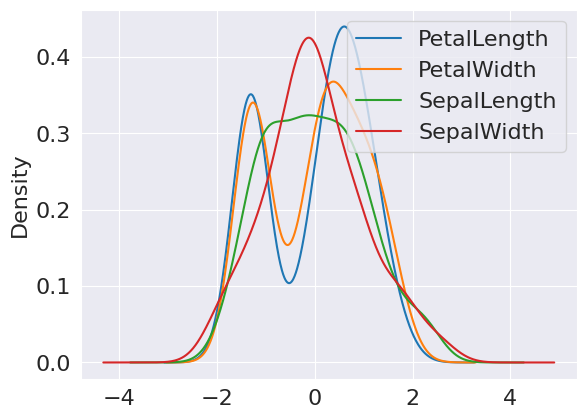

In [96]:
X_scaled.plot.density()

We decided to add some features to see if we can gain any useful information.


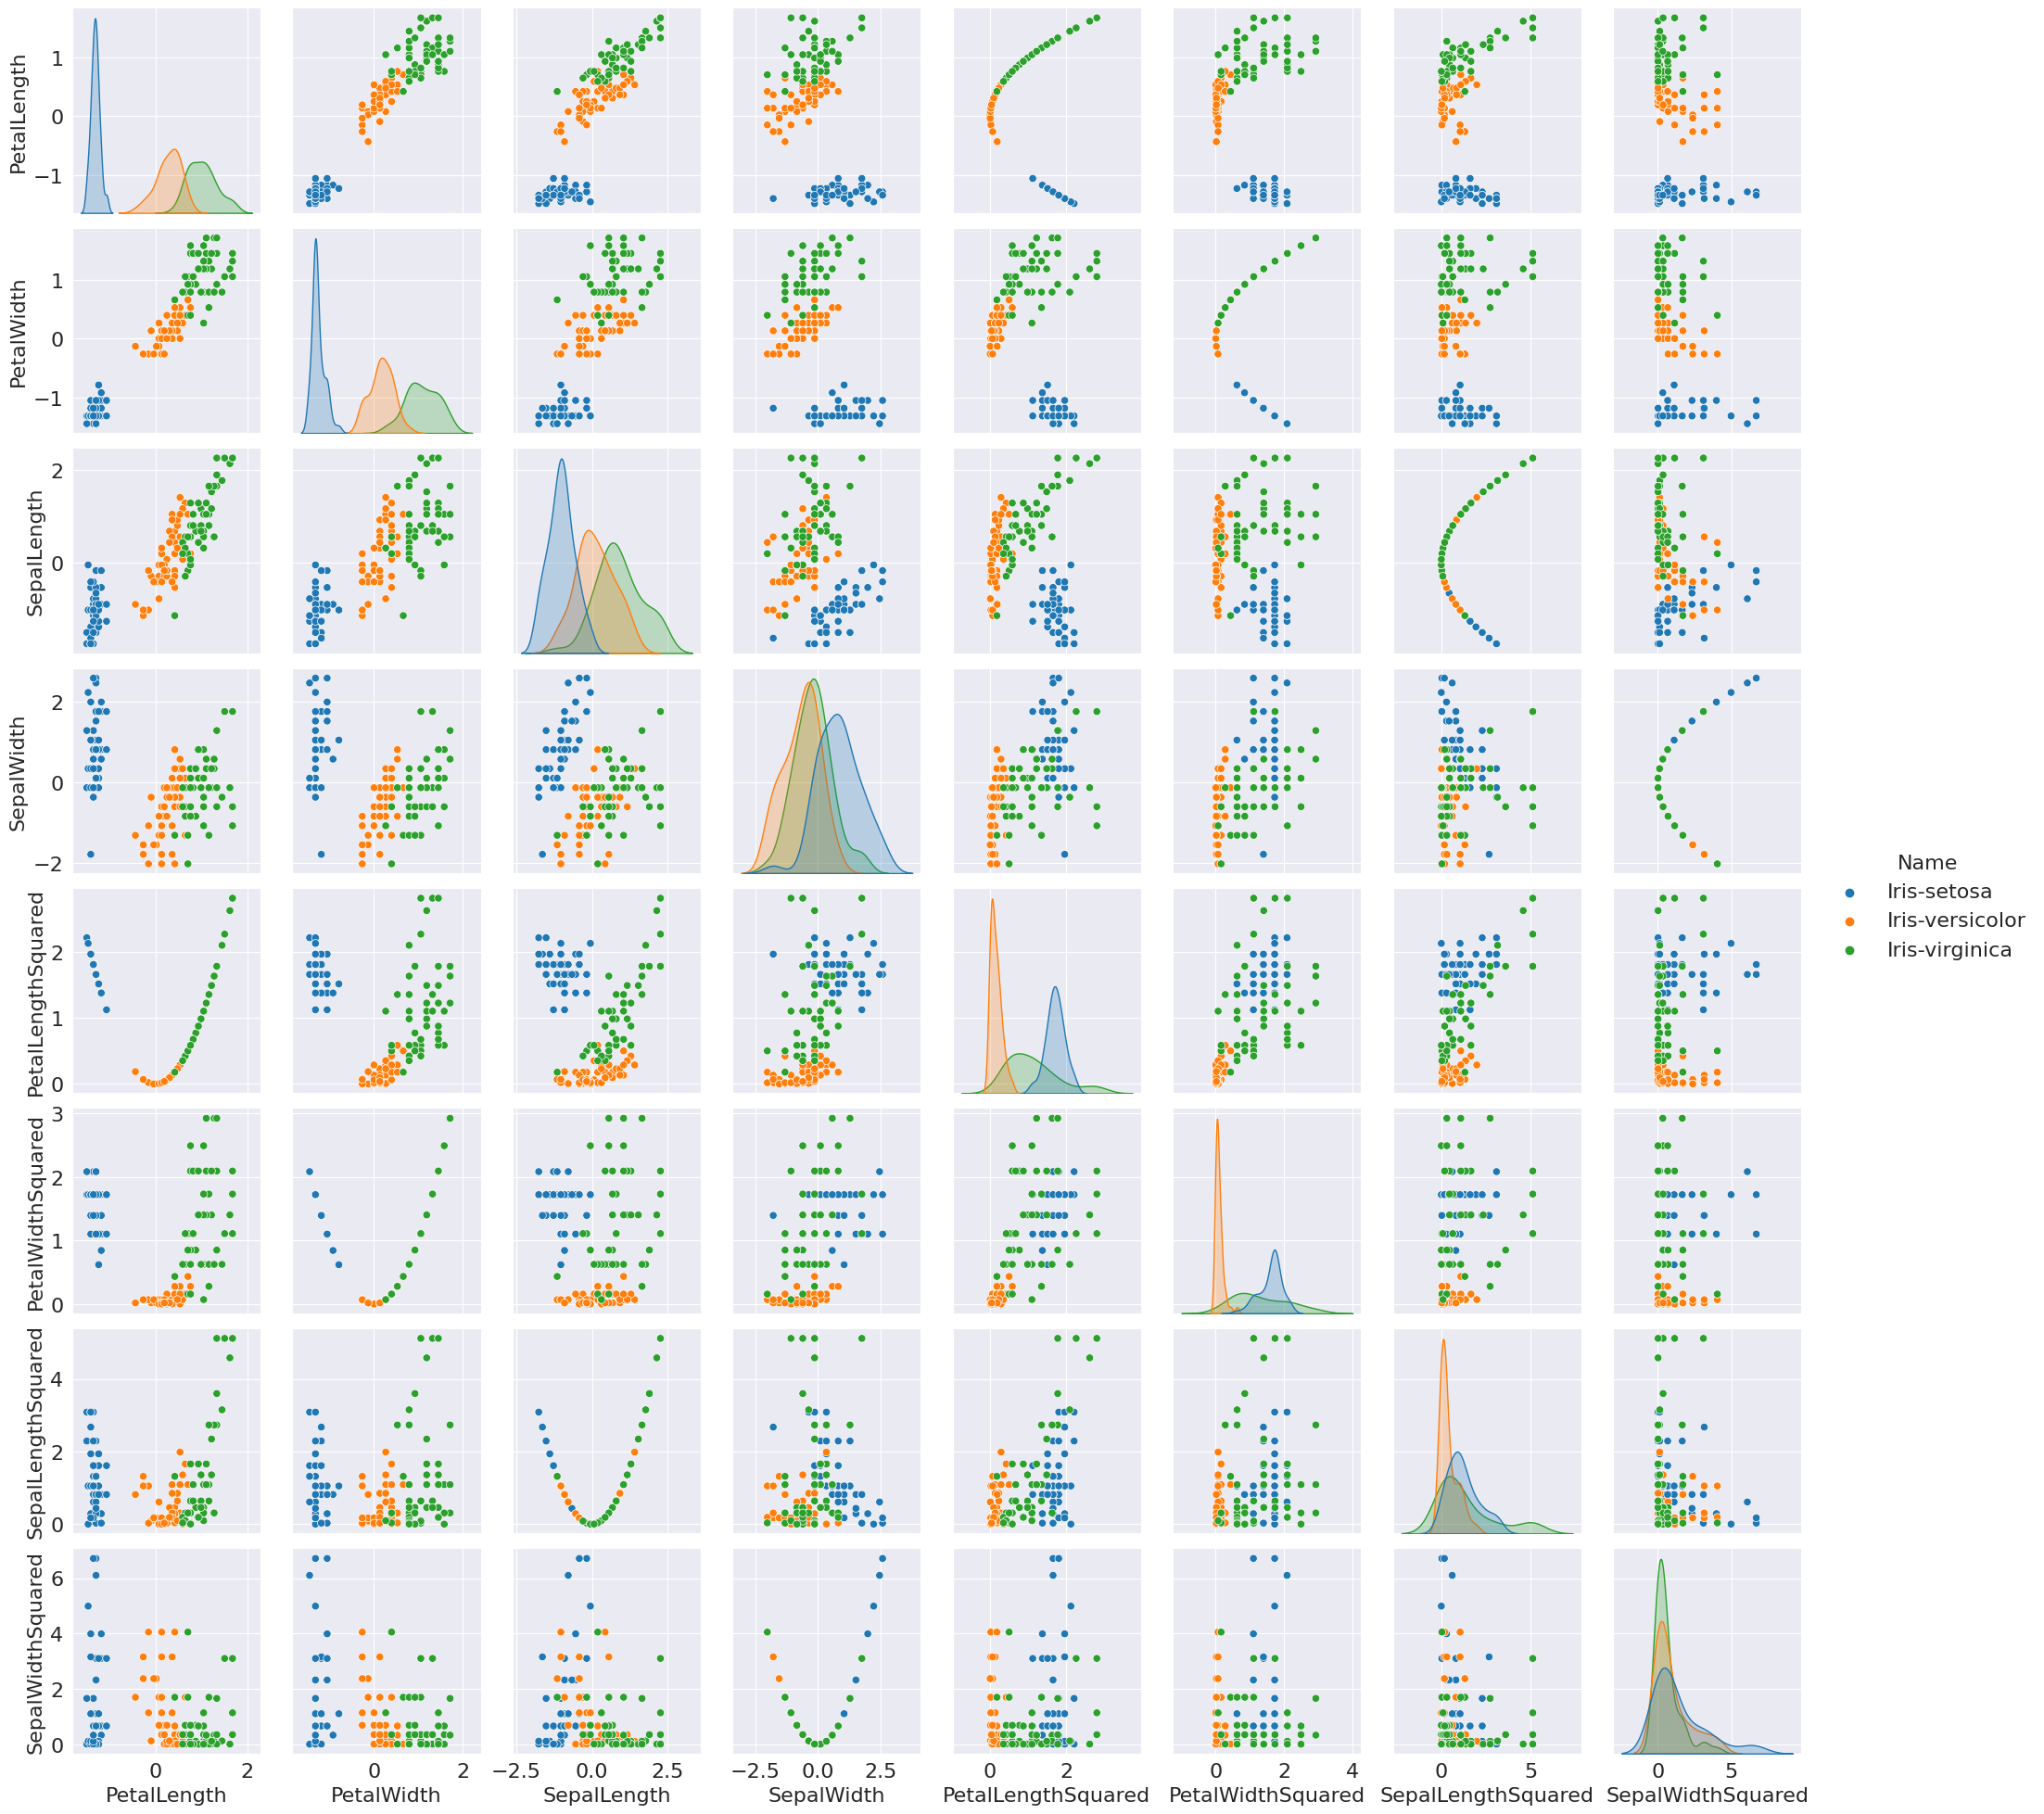

In [97]:
X_scaled["PetalLengthSquared"] = X_scaled["PetalLength"] * X_scaled["PetalLength"]
X_scaled["PetalWidthSquared"] = X_scaled["PetalWidth"] * X_scaled["PetalWidth"]
X_scaled["SepalLengthSquared"] = X_scaled["SepalLength"] * X_scaled["SepalLength"]
X_scaled["SepalWidthSquared"] = X_scaled["SepalWidth"] * X_scaled["SepalWidth"]

X_scaled["Name"] = y
sns.pairplot(X_scaled, hue="Name")
X_scaled.drop(columns=["Name"], inplace=True)  # remove target

* Are there any categorical features that need to be transformed so that it can be used for classification task?
    * No since all our features are numerical, we do not have any categorical features, besides the target feature `Name`.
* Do you think it makes sense to derive any more features from the given ones? Why/why not?
    * It could make sense, depending on the data. It is possible to generate information that can help a model perform better. Since we do not have a lot of samples we can definitely try to derive new features.
* Split up the dataset into a training and a separate held back test set in a clever way
    * Why is such a train/test split important?
        * A: So we can validate our model and check whether we just made a lookup table of our data. It's our last safety line and important to measure the performance of our model.
    * Which train/test split percentage do you choose and why?
        * A: we choose a 70/30 split since we do not have a lot of samples and want enough data to validate our model and 70 / 30 % of 150 are integers.
    * Think about how can you make sure to include samples from all three classes in both datasets and why this is important.
        * A: If a class has no samples in our training data, the model can at best make a wild guess if a sample of that class is passed to the model. We ensured that every class is represented by using `sklearn.model_selection.train_test_split` and supplying it with the `stratify` parameter.


In the lecture we learned that feture selection like PCA or LDA should only be applied to the training data and not the test data, so we need to split our data now, we used a 30/70 split where we use 70% of our data for training and 30% for validation.

* Use an appropriate cross-validation setup for the training:
    * `X_train` and `y_train` represents our training data and `X_train` and `y_train` our held back test set.

In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.30)  # 70/30 split

In [99]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_train

array([[ 1.70308594e+00,  1.13524781e+00, -1.81399871e+00,
         2.98908361e-01],
       [-2.90665411e+00,  3.65660779e+00,  2.09484320e+00,
         2.27144629e+00],
       [ 1.85086971e+00,  1.55207609e+00, -1.65385573e+00,
         6.72785901e-01],
       [ 1.71280230e+00,  1.29536052e+00, -1.85219404e+00,
         6.57532914e-01],
       [-1.33995949e+00, -6.24329330e-01, -5.34452416e-01,
        -2.32104489e-02],
       [-5.92711332e-01, -1.33872010e+00, -1.12121243e+00,
        -2.87631622e-01],
       [ 2.23067348e+00,  6.30233960e-01, -6.67794714e-01,
        -5.64088316e-01],
       [ 3.25569917e-01, -2.64780083e+00,  1.22395823e+00,
         1.36455156e+00],
       [-1.03123913e+00, -1.14862084e+00, -8.20185815e-01,
        -4.15265985e-01],
       [ 1.81753211e+00,  3.44986987e-01, -1.03778346e+00,
        -7.24579588e-01],
       [ 1.86856123e+00,  3.49943552e-01, -5.64416011e-01,
        -3.90089600e-02],
       [-9.80161590e-01, -1.26047856e+00, -7.83682126e-01,
      

* Train different classification models to distinguish between the three Iris Plant Species:
    * Use the following models: k Nearest Neighbour, Decision Tree, Support Vector Machine

In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm, neighbors, neural_network

knn = GridSearchCV(
    estimator= neighbors.KNeighborsClassifier(),
    param_grid= [{'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'leaf_size': [15, 20]}],
    scoring= "accuracy",
    cv= 3)

knn.fit(X_train, y_train)
knn.best_params_

{'leaf_size': 15, 'n_neighbors': 3, 'weights': 'uniform'}

In [101]:
from sklearn.tree import DecisionTreeClassifier

tree = GridSearchCV(
    estimator= DecisionTreeClassifier(),
    param_grid= [{
        'splitter': ['best', 'random'],
        'max_depth': [10, 100, 1000],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'class_weight': ['balanced']}],
        scoring= "accuracy",
        cv= 3
    )

tree.fit(X_train, y_train)
tree.best_params_

{'class_weight': 'balanced',
 'criterion': 'log_loss',
 'max_depth': 100,
 'splitter': 'best'}

In [102]:
from sklearn.utils.fixes import loguniform

svc = GridSearchCV(
    estimator= svm.SVC(),
    param_grid= [{
        'C': loguniform(0.1, 1, 100, 1000).rvs(20),
        'class_weight': ['balanced'],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': loguniform(0.000035, 0.000245).rvs(20)
    }]
)

svc.fit(X_train, y_train)
svc.best_params_

{'C': 930.5760347918847,
 'class_weight': 'balanced',
 'gamma': 4.064801075471876e-05,
 'kernel': 'linear'}

## Neural Network playground

In [103]:
nn = GridSearchCV(
    estimator=neural_network.MLPClassifier(),
    param_grid= [{
        'hidden_layer_sizes': [6, 9, 12],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adm'],
        'learning_rate': ['constant', 'ínvscaling', 'adaptive']
    }]
)

nn.fit(X_train, y_train)
nn.best_params_

/home/florian/projects/fh/mc/ml/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/florian/projects/fh/mc/ml/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/florian/projects/fh/mc/ml/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/florian/projects/fh/mc/ml/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

{'activation': 'logistic',
 'hidden_layer_sizes': 12,
 'learning_rate': 'adaptive',
 'solver': 'lbfgs'}

* Use different hyperparameter settings for each model and explain why and how you chose them
    * We selected each hyperparameter by trying different combinations, and then using the best fitting hyperparameters.

* Estimate the models’ performances on the held back test set:

In [104]:
knn.score(X_test, y_test)

0.9333333333333333

In [105]:
tree.score(X_test, y_test)

0.9333333333333333

In [106]:
svc.score(X_test, y_test)

0.8888888888888888

In [107]:
nn.score(X_test, y_test)

0.9333333333333333

* Compare the models with their hyperparameter settings with two different error/performance measures
* Why did you choose the specific error/performance measures?
    * We chose the build-in report feature of sklearn, since it includes different scoring algorithms and scores for each label
* What do they tell you?
    * It tells us how well a model performs on the held-back testset, for each label and overall

In [108]:
from sklearn.metrics import classification_report

y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      0.93      0.97        15
Iris-versicolor       0.83      1.00      0.91        15
 Iris-virginica       1.00      0.87      0.93        15

       accuracy                           0.93        45
      macro avg       0.94      0.93      0.93        45
   weighted avg       0.94      0.93      0.93        45



In [109]:
y_pred = tree.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.88      0.93      0.90        15
 Iris-virginica       0.93      0.87      0.90        15

       accuracy                           0.93        45
      macro avg       0.93      0.93      0.93        45
   weighted avg       0.93      0.93      0.93        45



In [110]:
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.78      0.93      0.85        15
 Iris-virginica       0.92      0.73      0.81        15

       accuracy                           0.89        45
      macro avg       0.90      0.89      0.89        45
   weighted avg       0.90      0.89      0.89        45



In [111]:
y_pred = nn.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.88      0.93      0.90        15
 Iris-virginica       0.93      0.87      0.90        15

       accuracy                           0.93        45
      macro avg       0.93      0.93      0.93        45
   weighted avg       0.93      0.93      0.93        45



* Which model performs best with which hyperparameter settings and why do you think it does that way?
    * The KNN and SVM Classifiers perform the best, because each Label is mostly cleanly seperated from the others.

In [112]:
knn.best_params_

{'leaf_size': 15, 'n_neighbors': 3, 'weights': 'uniform'}

In [113]:
svc.best_params_

{'C': 930.5760347918847,
 'class_weight': 'balanced',
 'gamma': 4.064801075471876e-05,
 'kernel': 'linear'}

* Explain which model you would use in deployment and why
    * We would use the knn model, since it's the simplest model with the best score.